## 1. Exploratory Data Analysis

We are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with.

In [ ]:
# set matplotlib backend to inline
%matplotlib inline

# import modules
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']


# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data


#### First lets get an overview of the training data and the labels by printing their shapes.

In [ ]:
# Print the shape of features X, and target y
print("Shape of features X: {}".format(X.shape))
print("Shape of tagret y: {}".format(y.shape))

Shape of features X: (178, 4)
Shape of tagret y: (178,)


#### Above output shows training data has 4 columns and 178 records. The target labels has 178 records as well.

#### Next we will plot the visualizations between them to see how they interact with each other and how they are distributed.

In [ ]:
# define plotting function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def myplotGrid(X, y, selected_features):
    '''Shows vsiualizations to demonstrate how features interact with each other, and how they are distributed.

    Parameters: features, target label and the selected features.
    Output: A grid if subplot with Scatter plot visualizations to show how features interact with each other
    and Histogram to show how a feature is distributed.
    '''
    totalFeatures = len(selected_features)       #getting the total number of features to consider
    uniqueTargetLabels = np.unique(y)            #getting the unique labels in target y

    #creating a grid to display visualizations with rows = number of features and columns = number of features.
    fig, ax = plt.subplots(X.shape[-1], X.shape[-1], figsize=(13, 13))

    classColors = ['red', 'blue', 'green']      #colors to represent each unique class in scatterplot

    #Nestted loop that first loops over the number of features, then loops over the number of features again
    for a in range(totalFeatures):
        for b in range(totalFeatures):
            #if both loops have index on same feature display the feature distrbution using histogram
            if a == b:
                #Draw the feature distribution histogram with color purple
                ax[a, b].hist(X[:,a], color='purple', alpha=0.7)
                ax[a,b].set_xlabel(selected_features[a])      #Set the current feaure as x-axis label
                ax[a,b].set_ylabel('Freq')                    #Set the y-axis label as 'Freq'
            #If both loops have different index display how they interact with other fearures using scatter plot
            else:
                c = 0      #variable that will store how many times loop has iterated
                #loop over the unique labels in target y
                while c < len(uniqueTargetLabels):
                    #store the indexes of each unique target y
                    indexes = np.where(y == uniqueTargetLabels[c])
                    #draw scatterplot to show how both features interact,show unique labels with different colors
                    ax[a, b].scatter(X[indexes, b], X[indexes, a], color = classColors[c], linewidths=0.8,
                                     alpha=0.6, label= uniqueTargetLabels[c])
                    c +=1
                #set the x-axis label to the feature that is represented by the index of the outerloop
                ax[a,b].set_xlabel(selected_features[b])
                #set the y-axis label to the feature that is represented by the index of the innerloop
                ax[a,b].set_ylabel(selected_features[a])

    #Get the labels from scatterplot
    handles, labels = ax[2,1].get_legend_handles_labels()
    #Display legend that classify colors that represent a class
    fig.legend(handles,uniqueTargetLabels,loc ='right',title="Classes",fontsize=12, title_fontsize = 14)
    plt.tight_layout()                               #Adjust space between graphs
    plt.subplots_adjust(wspace=0.3, hspace=0.3)      #tune the plots width and height
    plt.show()                                       #Show the Visualization

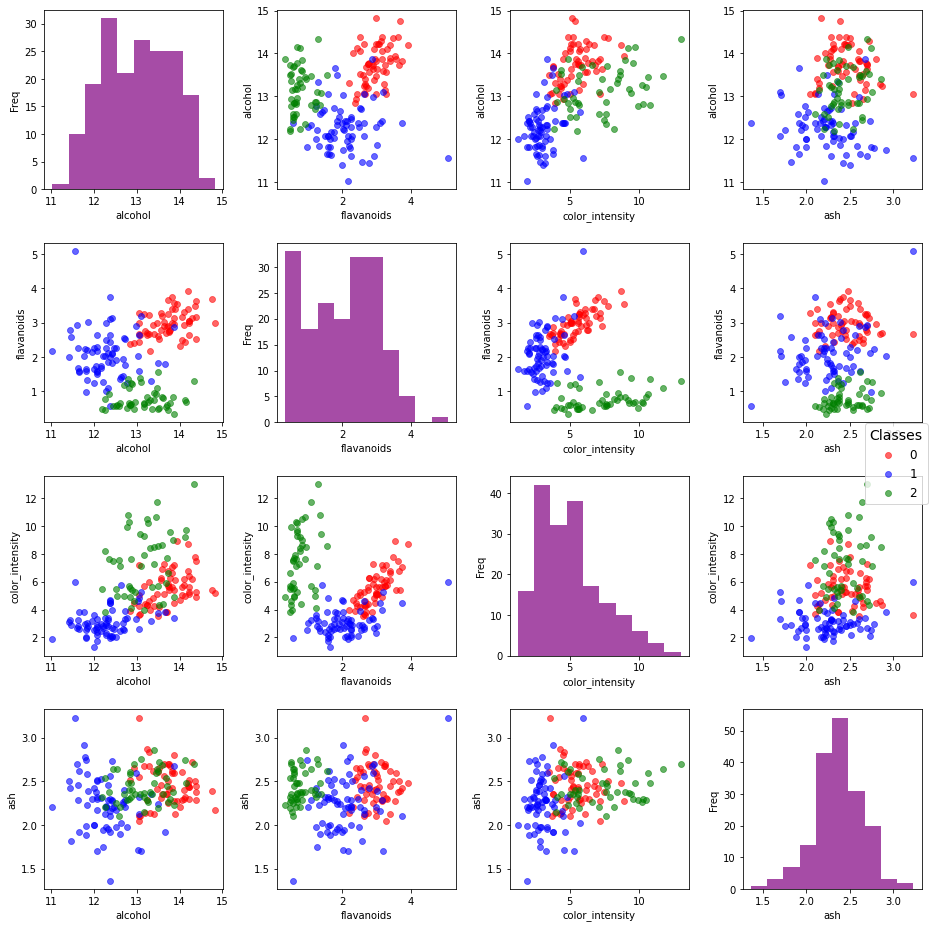

In [ ]:
#call the visualization function
myplotGrid(X, y, selected_features)

#### We've successfully displayed visualizations of the selected features. Each row represents a feeature, where a  histogram shows how it is distributed while scatter plot shows how this feature interacts with other features.

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell we will invoke our exploratory data analysis function above on a noisy version of your data X.


#### Now we will add some Gaussian noise to our data X to display its noisy version.

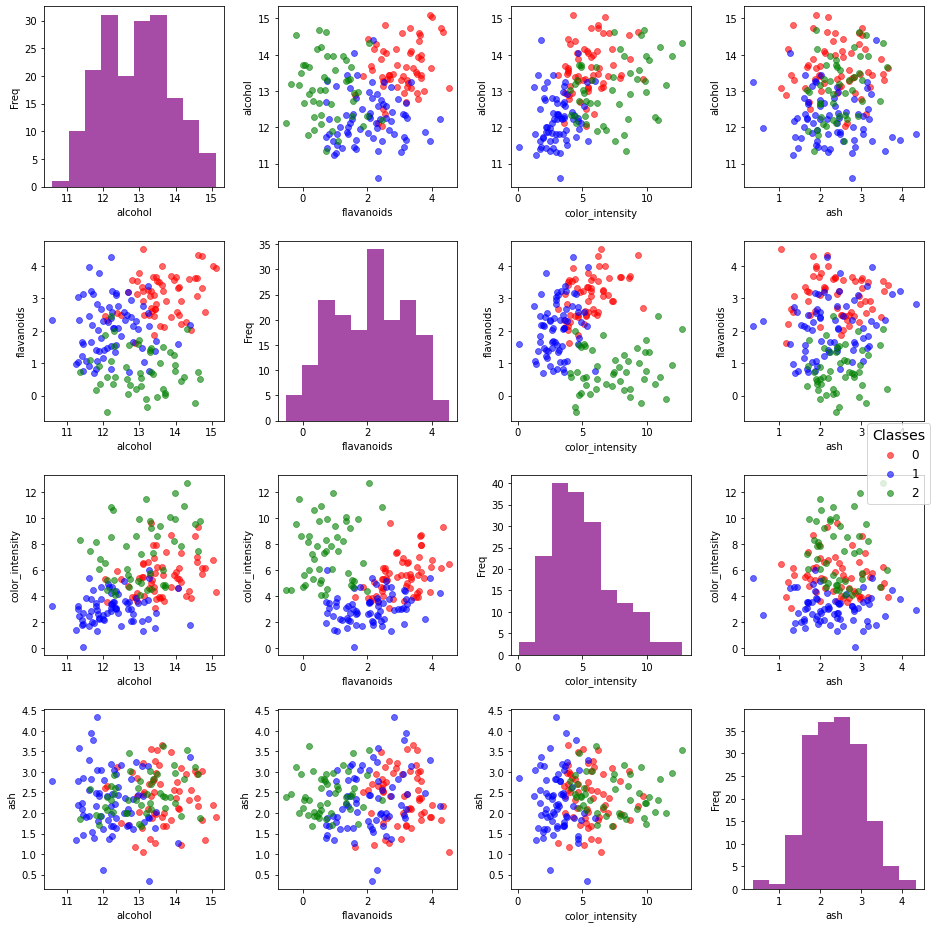

In [ ]:
# noise code
mySeed = 12345
np.random.seed(mySeed)
#Gaussian noise being added
XN=X+np.random.normal(0,0.6,X.shape)
#call the visualization function
myplotGrid(XN,y,selected_features)

## 2. Implementing kNN


In [ ]:
# helper code

#Calculates the euclidean or manhattan distance between a point in testing data and each point of training data
def getDistances(X,X_,distanceType):
    '''
    Based on the distance type specified caclculates the distance of the testing data point with each point of
    testing data then returns these distances as a list.

    parameters: Point of testing data, list of training data, and distance type.

    output: returns a list of distances
    '''

    #list to store the distances
    distances = []

    #loop over each point of Training data
    for j in X:
        #if distance type is euclidean perform euclidean distance
        if distanceType == 'euclidean':
            #euclidean distance formula applied
            distance = np.sqrt(np.sum((np.array(j) - np.array(X_)) ** 2))
        #if distance type is manhattan perform manhattan distance
        elif distanceType == 'manhattan':
            #manhattan distance formula applied
            distance = np.sum(abs(np.array(j) - np.array(X_)))
        #appending the distance of X_ with current value of point X
        distances.append(distance)
    #return the distances array
    return distances

#Calculates the nearest neighbors of each point in testing data with each point of training data.
def getNearestNeightbour(distances, k):

    '''
    Loops over the the 2d array to perform argsort inside each list in the distances array. The lists then contains
    the index of sorted values in each list where nearest k values for each list are stored in a new 2d array.

    parameters:
    1) 2d array of distances:consists of lists, each list represents the distance of a testing data point
    with evey point in training data.
    2) k value that represents the nearest neighbours to look for

    output: returns a new 2d array where each list inside it has k nearest sorted values represented by their index.
    '''

    #variable that will store 2d array where each list have specified k nearest neighbors of a point in testing data
    kNearest = []
    #looping over distances array to get access over each list
    for distance in distances:
        #sort each list and only keep the nearest values equal to k. The append the new list to nearest 2d array
        kNearest.append(np.argsort(distance, kind='quicksort')[:k])
    #return the nearest 2D-array
    return kNearest

def getPredictedLabel(y, NearestNeigbours,weightMethod):
    '''
        Returns a list that shows the predicted target variable for each testing data

        parameters: NearestNeighbours: 2D array that stores specified nearest neighbors of each point
        in testing data with each point of training data.
        Weight Method: the specified method used to find the target label

        Output: list that contains target labels of each point of testing data
    '''

    #values is 2d-array stores labels
    values = []
    #looping over the NearestNeigbours 2d array to get the labels.
    for x in NearestNeigbours:
        labelY = y[x]
        values.append(labelY)
#     print(values)
    #list to store predicted labes
    labels=[]
    #if weight method is uniform give all neighbours the same weightage
    if weightMethod == 'uniform':
        #loop over 2d array values
        for v in values:
            #predict labels for each v(list) using the bincount to calculate number of instances of each value and
            #based on this use argmax to get the value that appeared the most
            labels.append(np.argmax(np.bincount(v)))
        #return the labels list
        return labels


In [ ]:
# mykNN code

#function that will predict the labels for input data
def mykNN(X,y,X_,options):
    #k stores that value of the number of nearest neighbours to consider.
    k = options[0]
    #Stores the type of distance to be used
    distanceType = options[1]
    #Get the weight method to be used
    weightMethod = options[2]
    #Initializing a list that will store predicted outputs
    y_ = []

    #2D array that will store distances between each point of X_(testing data) with each point of X(training data)
    Distances = []

    #looping over each point of testing data
    for i in X_:
        #function call returns list of distances of currect value of testing data with
        #each point of X based on distance type
        dist = getDistances(X,i,distanceType)
        #Appending that list to the 2d array that stores all the distances of each point of X_ with each point of X.
        Distances.append(dist)
    #function that returns the indexes of nearest neighbours
    NearestNeigbours = getNearestNeightbour(Distances,k)
    #Function that gets the predicted labels
    y_ = getPredictedLabel(y, NearestNeigbours, weightMethod)

    #return the predicted outputs
    return y_



In [ ]:
# Sample training data and labels
trainX = np.array([[35, 40], [42, 55], [50, 50], [20, 29], [80, 99], [100, 100], [0, 0], [30, 18]])
trainY = np.array([0, 0, 1, 0, 1, 1 ,0, 0])

# Sample testing data
testX = np.array([[35, 49], [59, 88],[65, 34], [5, 41]])
testY= np.array([0,2])

options =[3, 'euclidean', 'uniform']
#function to do the k-nearest algorithm in order to get the predicted testing data
predY_ = mykNN(trainX,trainY,testX,options)
print(predY_)

[0, 1, 0, 0]


#### Verifying the result using the knn Classifier  from scikit library

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#define knn classifier, with 5 neighbors and use the euclidian distance
knn=KNeighborsClassifier(n_neighbors=3, metric='euclidean')
#define training and testing data, fit the classifier
knn.fit(trainX,trainY)
#predict values for test data based on training data
y_pred=knn.predict(testX)
print(y_pred)

[0 1 0 0]


## 3. Classifier evaluation



In [ ]:
# Setting the random seed to produce reproducible results
seed_value = 32
np.random.seed(seed_value)

# Sample data produced
yActual = np.random.randint(0,3, size=10)
yPred =  np.random.randint(0,3, size=10)

#print the data
print(yActual)
print(yPred)

[1 2 0 2 0 0 2 1 1 2]
[1 0 1 1 2 0 2 2 2 0]


In [ ]:
def GetUniqueLabels(yActual, yPred):
    #list to store all elements of actual and predicted label
    y = []
    #loop to append predicted labels in new list
    for o in yPred:
        y.append(o)
    #loop to append actual labels in new list
    for o in yActual:
        y.append(o)

    uniqueLabels = np.unique(y)
    return uniqueLabels

#Caclulates the confusion matrix
def getConfusionMatrix(yActual, yPred):
    '''Returns a confuson matrix by finding unique labels, creating a confusion matrix of size equal to no. of
    unique labels * no. of unique labels. Then caculates the position where incrementing should be done.

    parameters: actual labels, predicted labels

    output: Return a confusion matrix
    '''



    #Get the unique labels from list containing both actual and predicted labels
    uniqueLabels = GetUniqueLabels(yActual, yPred)
    #Get to number of unique classes
    totalUniqueLabels = len(uniqueLabels)
    #initialize confusion matrix with rows x columns = no.of classes * no.of classes
    confusionMatrix = np.zeros((totalUniqueLabels, totalUniqueLabels))

    #loop over the actual label
    for i in range(len(yActual)):
            #for same index in actual and predicted label increment at that position the confusion matrix
            confusionMatrix[yActual[i],yPred[i]]+=1
    #return the confusion matrix
    return confusionMatrix

#Caclulates the accuracy
def getAccuracy(yActual, y_pred):
    '''Caculates the accuracy by using actual and predicted labels

    parameters: Actual labels and predicted labels

    Output: Returns the accuracy
    '''

    #get the length of total number of predicted data
    totalPredictions = len(yActual)
    #initialize variable that will store labels that were same for both actual and predicted data
    truePredictions = 0
    #Comparing acutal labels with predicted labels to see which labels match and which did not
    values = yActual == y_pred
    #loop over values variable to see if there is a true then inclrement true predicition by 1
    for i in values:
        #if labels match and there is a true value for it increment true predictions
        if i:
            #increment true true predicition
            truePredictions +=1
    #formula to find accuracy
    accuracy = truePredictions/totalPredictions
    #return accuracy
    return accuracy

#Caclulates the error rate
def getErrorRate(yActual, yPred):

    '''Caculates the error rate by using actual and predicted labels

    parameters: Actual labels and predicted labels

    Output: Returns the error rate
    '''
    uniqueLabels = GetUniqueLabels(yActual, yPred)

    #get the length of total number of predicted data
    totalPredictions = len(yPred)
    #initialize variable that will store labels that were not same for both actual and predicted data
    falsePredictions = 0
    #Comparing acutal labels with predicted labels to see which labels did not match
    values = yActual != yPred
    #loop over values variable to see if there is a true then inclrement true predicition by 1
    for i in values:
        #if labels did not match and there is a true value for it increment false predictions
        if i:
            #incrementing false predictions
            falsePredictions +=1
    #formula to get error rate
    errorRate = falsePredictions/totalPredictions
    #return the error rate
    return errorRate


confusionMatrix = getConfusionMatrix(yActual, yPred)

accuracy = getAccuracy(yActual, yPred)
errorRate = getErrorRate(yActual, yPred)

print('------------------------\n')
print('Confusion Matrix: \n\033[91m{}\033[00m'.format(confusionMatrix))
print('\n------------------------\n')
print('\033[95mAccuracy:\033[00m{}\n\033[95mError Rate:\033[00m {}'.format(accuracy,errorRate))
print('\n------------------------')

------------------------

Confusion Matrix: 
[[1. 1. 1.]
 [0. 1. 2.]
 [2. 1. 1.]]

------------------------

Accuracy:0.3
Error Rate: 0.7

------------------------


#### Verifying the confusion Matrix, Accuracy and Error Rate using Scikit Learn Library

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Confusion Matrix using Sklearn:\n{}'.format(confusion_matrix(yActual,yPred)))
print('Accuracy using sklearn: {}'.format(accuracy_score(yActual,yPred)))
errorR = 1 - accuracy_score(yActual,yPred)
print('Error Rate using skLearn: {}'.format(errorR))

Confusion Matrix using Sklearn:
[[1 1 1]
 [0 1 2]
 [2 1 1]]
Accuracy using sklearn: 0.3
Error Rate using skLearn: 0.7


In [ ]:
#Caclulates the precsion for a label
def getPrecision(yActual, yPred, classVal):

    '''Calculate the precision for a certain class label.

    parameters: Actual Labels, Predicted Labels and Label to computer precision for

    Output: Returns the precison

    '''

    #initialize variable to store the positive predictions
    predictedYes = 0
    #initialize variable to store the correct true prediction
    truePositive = 0
    #variable that will store precision
    precision= 0
    #function call to get the confusion matrix
    confusionMatrix = getConfusionMatrix(yActual, yPred)

    #loop over the rows of confusion matrix
    for row in range(len(confusionMatrix)):
            #increment predicted yes
            predictedYes +=confusionMatrix[row,classVal]
            #condition checks if row is equal to classVal then gets the true positve and stores it
            if row == classVal:
                #stores the true positive
                truePositive = confusionMatrix[row,classVal]
    #formula applied to get precision
    precision = (truePositive/predictedYes)
    #returns the precision
    return precision

#Caclulates the average precision of all labels
def getAveragePrecision(yActual, yPred):

    '''Calculate the average precision for all labels of actual and predicted data

    Parameters: Actual Data, Predicted Data

    Output: returns the Average Precision

    '''

    #Get the unique labels
    uniqueLabels = GetUniqueLabels(yActual, yPred)
    #variable to store average precision
    averagePrecision = 0
    #variable to store sum of predictions, will be used in formula to get average precision
    sumOfPrecisions = 0
    #Get the length on number of unique labels
    totPrecisions = len(uniqueLabels)
    #loop over unique labels to get precision for each label
    for u in range(len((uniqueLabels))):
        #Get the precision for a label and add it to to variable sumOfPrecisions
        sumOfPrecisions+= getPrecision(yActual, yPred,uniqueLabels[u])
    #average precision formula applied
    averagePrecision = sumOfPrecisions/totPrecisions
    #return average precision
    return averagePrecision

#function call to get average precision
averagePrecision = getAveragePrecision(yActual, yPred)

#dotted line printed to make output more readable
print('------------------------\n')
#Loop over unique labels to print precision for each label
for i in range(len(GetUniqueLabels(yActual, yPred))):
    print('\033[95mPrecision for class {}\033[00m: {}'.format(i,getPrecision(yActual,
                                                                             yPred,GetUniqueLabels(yActual, yPred)[i])))
#dotted line printed to make output more readable
print('\n------------------------\n')
#print the average precision
print('\033[95mAverage Precision\033[00m: {}'.format(averagePrecision))


------------------------

Precision for class 0: 0.3333333333333333
Precision for class 1: 0.3333333333333333
Precision for class 2: 0.25

------------------------

Average Precision: 0.3055555555555555


#### Verifying precision using scikit learning Library

In [ ]:
#import sklearn libraries
from sklearn.metrics import precision_score
#Get Precision for all labels
skLearnPrecision = precision_score(yActual, yPred,average=None)

#Get unique labels
uniqueLabels = GetUniqueLabels(yActual, yPred)
#Print sklearn precision for all labels
for i in range(len(skLearnPrecision)):
    print('Precision for Class Label {}: {}'.format(uniqueLabels[i],skLearnPrecision[i]))

Precision for Class Label 0: 0.3333333333333333
Precision for Class Label 1: 0.3333333333333333
Precision for Class Label 2: 0.25


In [ ]:
#function to get recall of a label
def getRecall(yActual, yPred, classVal):

    '''Calculate the recall for a certain class label.

    parameters: Actual Labels, Predicted Labels and Label to computer recall for

    Output: Returns the recall

    '''

    #function call to get the confusion matrix
    confusionMatrix = getConfusionMatrix(yActual, yPred)
    #initialize variable to store the actual positive predictions
    ActualYes = 0
    #initialize variable to store the correct true prediction
    truePositive = 0
    #variabele that will store the recall
    recall= 0

    #loop over the columns of confusion matrix
    for col in range(len(confusionMatrix)):
            #increment actual yes
            ActualYes +=confusionMatrix[classVal, col]
            #checks if col is equal to classVal then get the true positve and store it
            if col == classVal:
                #stores the true positive
                truePositive = confusionMatrix[classVal,col]
    #recall formula applied
    recall = truePositive/ActualYes
    #returns the recall
    return recall

#function to get average recall for all labels
def getAverageRecall(yActual, yPred):

    '''Calculate the average recall for all labels of actual and predicted data

    Parameters: Actual Data, Predicted Data

    Output: returns the Average Recall

    '''
    #Get the unique labels
    uniqueLabels = GetUniqueLabels(yActual, yPred)
    #variable to store average recall
    averageRecall = 0
    #variable to store sum of recall, will be used in formula to get average recall
    sumOfRecalls = 0
    #Get the length on number of unique labels
    totRecalls = len(uniqueLabels)
    #loop over unique labels to get recall for each label
    for u in uniqueLabels:
        #Get the precision for a label and add it to the variable sumOfRecalls
        sumOfRecalls+= getRecall(yActual, yPred, u)
    #average averageRecall formula applied
    averageRecall = sumOfRecalls/totRecalls
    #return the average recall
    return averageRecall

#function call to get average recall
averageRecall = getAverageRecall(yActual, yPred)

#dotted line printed to make output more readable
print('------------------------\n')
#Loop over unique labels to print recall for each label
for i in range(len(GetUniqueLabels(yActual, yPred))):
    print('\033[93mRecall for class {}\033[00m: {}'.format(i,getRecall(yActual, yPred,i)))
#dotted line printed to make output more readable
print('\n------------------------\n')
#print the average recall
print('\033[93mAverage Recall\033[00m: {}'.format(averageRecall))

------------------------

Recall for class 0: 0.3333333333333333
Recall for class 1: 0.3333333333333333
Recall for class 2: 0.25

------------------------

Average Recall: 0.3055555555555555


#### Verifying the Recall using the scikit learn library

In [ ]:
#import sklearn libraries
from sklearn.metrics import recall_score

#Get the recall of all labels
skLearnRecall = recall_score(yActual, yPred,average=None)
#Get unique labels
uniqueLabels = GetUniqueLabels(yActual, yPred)
#Print sklearn recall for all labels
for i in range(len(skLearnRecall)):
    print('Recall for Class Label {}: {}'.format(uniqueLabels[i],skLearnRecall[i]))



Recall for Class Label 0: 0.3333333333333333
Recall for Class Label 1: 0.3333333333333333
Recall for Class Label 2: 0.25


In [ ]:
#funvtion to get the f-beta score
def fBetaScore(yActual,yPred,beta, label):
    '''Calculates the the f0.5, f1 or f2 score for the desired label from the Actual and predicted labels.

    parameters: Actual Labels, Predicted Labels, desired FBeta score, class label

    output: 'Outputs the f-beta score'

    '''
    #Function call to store the precision for the desired label
    precision = getPrecision(yActual, yPred,label)
    #Function call to store the recall for the desired label
    recall = getRecall(yActual, yPred,label)

    #initiating variable that will store the f-beta score
    fBetaScore = 0
    #variable that stores the string to print if the beta score required is incorrect
    incorrectBeta = 'Error, Please enter a Beta Score from 0.5,1,2'

    #below conditions are used toto check which beta score is required, according to it apply the appropriate
    #forumula and return the f-beta score

    #if fbeta is 0.5. more weightage is given to precision
    if beta == 0.5:
        fBetaScore = (precision * recall * 1.25 ) / ( precision + recall * 0.25)
        return fBetaScore
    #if fbeta is w. more weightage is given to recall
    elif beta == 2:
        fBetaScore = (precision * recall * 5  ) / ( precision + recall * 4)
        return fBetaScore
    #if fbeta is 1. equal weightage is given to precision and recall
    elif beta == 1:
        fBetaScore = (precision * recall * 2) / (precision + recall)
        return fBetaScore
    else:
         return incorrectBeta

#list contains all the valid beta score options that can be calculated
beta = [0.5, 1, 2]
#Dotted line printed to make our output more readable
print('-----------------------------------------------')
#Loop over the unique labels to print f-beta score for all
for i in range(len(GetUniqueLabels(yActual, yPred))):
    #loop over valid beta scores to find all beta score for each label
    for j in range(len(beta)):
        #Print the fbeta score, to make output more readable green color is applied
        print('\033[92mF{} Score for Class Label {}\033[00m: {}'.format(beta[j],
                                                                        i,fBetaScore(yActual,yPred,beta[j], i)))
    #Dotted line printed to make our output more readable
    print('-----------------------------------------------')

-----------------------------------------------
F0.5 Score for Class Label 0: 0.33333333333333337
F1 Score for Class Label 0: 0.3333333333333333
F2 Score for Class Label 0: 0.33333333333333337
-----------------------------------------------
F0.5 Score for Class Label 1: 0.33333333333333337
F1 Score for Class Label 1: 0.3333333333333333
F2 Score for Class Label 1: 0.33333333333333337
-----------------------------------------------
F0.5 Score for Class Label 2: 0.25
F1 Score for Class Label 2: 0.25
F2 Score for Class Label 2: 0.25
-----------------------------------------------


#### Verifying the f-beta score using scikit learn library

In [ ]:
#import the sklearn libraries
from sklearn.metrics import fbeta_score

#Get unique labels
uniqueLabels = GetUniqueLabels(yActual, yPred)

#get the f-beta scores
skLearnFScore0 = fbeta_score(yActual, yPred, average=None, beta=0.5)
skLearnFScore1 = fbeta_score(yActual, yPred, average=None, beta=1)
skLearnFScore2 = fbeta_score(yActual, yPred, average=None, beta=2)

#Print sklearn f0.5 score for all labels
for i in range(len(skLearnFScore0)):
    print('F0.5 for Class Label {}: {}'.format(uniqueLabels[i],skLearnFScore0[i]))
    print('F1 for Class Label {}: {}'.format(uniqueLabels[i],skLearnFScore1[i]))
    print('F2 for Class Label {}: {}'.format(uniqueLabels[i],skLearnFScore2[i]))



F0.5 for Class Label 0: 0.3333333333333333
F1 for Class Label 0: 0.3333333333333333
F2 for Class Label 0: 0.3333333333333333
F0.5 for Class Label 1: 0.3333333333333333
F1 for Class Label 1: 0.3333333333333333
F2 for Class Label 1: 0.3333333333333333
F0.5 for Class Label 2: 0.25
F1 for Class Label 2: 0.25
F2 for Class Label 2: 0.25


This conclude the Classifier Evaluation Section. I've tried to create function that are stand alone in a way that whenever</br>  a anyone calls them they only need to pass predicted and actual data and in some case class label to get the output


 Nested Cross-validation using your implementation of KNN  


In [ ]:
x = [[3,4],[5,6],[1,2],[2,3],[5,5],[8,8],[4,7],[3,3],[9,0],[7,7]]
y = [1010101010]

# Set a random seed for reproducibility (optional)
# random.seed(42)

# Define the proportion of data for training and testing
for i in range(0,5):
    train_ratio = 0.8  # 80% for training, 20% for testing
    total_samples = len(x)
    train_size = int(total_samples * train_ratio)
    print(train_size)


# Shuffle the data randomly
# random.shuffle(data)

# Split the data into training and testing sets
    train_data = x[:train_size]
    test_data = x[train_size:]
    print(train_data)
    print(test_data)

8
[[3, 4], [5, 6], [1, 2], [2, 3], [5, 5], [8, 8], [4, 7], [3, 3]]
[[9, 0], [7, 7]]
8
[[3, 4], [5, 6], [1, 2], [2, 3], [5, 5], [8, 8], [4, 7], [3, 3]]
[[9, 0], [7, 7]]
8
[[3, 4], [5, 6], [1, 2], [2, 3], [5, 5], [8, 8], [4, 7], [3, 3]]
[[9, 0], [7, 7]]
8
[[3, 4], [5, 6], [1, 2], [2, 3], [5, 5], [8, 8], [4, 7], [3, 3]]
[[9, 0], [7, 7]]
8
[[3, 4], [5, 6], [1, 2], [2, 3], [5, 5], [8, 8], [4, 7], [3, 3]]
[[9, 0], [7, 7]]


In [ ]:


def kFoldSplit(data, numOfFolds):
    n = len(data)
    fold_size = n // numOfFolds
    remainder = n % numOfFolds

    folds = []
    start = 0

    for i in range(numOfFolds):
        if i < remainder:
            end = start + fold_size + 1
        else:
            end = start + fold_size

        folds.append(data[start:end])
        start = end

    return folds


def outerLoopSplit(folds, foldCount, numOfFolds):
        test_fold = folds[foldCount]

        train_folds = []
        for i in range(numOfFolds):
            if i!= foldCount:
                train_folds.append(folds[i])

        X_train = []
        X_train_sub = []
        for x in train_folds:
            for i in x:
                X_train_sub = [X[i]]
            X_train.append(X_train_sub)

        y_train = y[[i for f in train_folds for i in f]]
        X_test = X[test_fold]
        y_test = y[test_fold]

        return test_fold, train_folds, X_train, y_train, X_test, y_test

def innerLoopSplit(i ,numOfFolds, train_folds):
        val_fold = train_folds[i]

        train_fold = []
        for a in range(numOfFolds - 1):
            if a!= i:
                train_fold.append(train_folds[a])


        X_val_inner = X[val_fold]
        y_val_inner = y[val_fold]

        X_train_inner = X[[i for f in train_fold for i in f]]
        y_train_inner = y[[i for f in train_fold for i in f]]

        return train_fold, X_val_inner, y_val_inner, X_train_inner, y_train_inner


def myNestedCrossVal(X, y, numOfFolds, nearestNeighbours, distanceTypes, seedVal):

    #settinf the random seed to get reporducible results
    np.random.seed(seedVal)

    #splitting the data range for five folds
    dataRange = range(X.shape[0])
    rangeList=[]
    for i in dataRange:
        rangeList.append(i)

    #Shuffling data range list to get random data for each fold
    np.random.shuffle(rangeList)

    # Perform nested cross-validation for each fold
    folds = kFoldSplit(rangeList, numOfFolds)


    #List to store mean accuracy for each fold
    foldAccuracy = []

    #stroing count for while loop
    foldCount = 0

    #looping over the total number of folds
    while foldCount < numOfFolds:

        #Splitting testinf and training data for outer loop

        test_fold, train_folds, X_train, y_train, X_test, y_test = outerLoopSplit(folds, foldCount, numOfFolds)

        best_accuracy = 0
        best_params = {'k': None, 'distanceType': None}

        eachAccuracyInFold = []
        highAccuracyOfEachFold = 0
        bestK = 0
        bestDistanceType = 0

        for k in nearestNeighbours:
            for distanceType in distanceTypes:
                accuracy_sum = 0

                #loop over number of loops - 1
                for i in range(numOfFolds - 1):
                    #function call to split testing and training data for innner loop
                    train_fold, X_val_inner, y_val_inner, X_train_inner, y_train_inner = innerLoopSplit(i, numOfFolds, train_folds)

                    #options list to store parameters such as distance method and k nearest for knn function
                    options = [ k, distanceType, 'uniform']
                    #calling the knn function by giving the test train data and options lists
                    y_pred_val = mykNN(X_train_inner, y_train_inner, X_val_inner, options)

                    #function call to get accuracy for each predicted label and actual labels list
                    accuracy_sum += getAccuracy(y_val_inner, y_pred_val)

                #mean average accuracy for current fold
                avg_accuracy = accuracy_sum / (numOfFolds - 1)

                eachAccuracyInFold.append([distanceType, k, avg_accuracy])
#                 print(f"   Validation Accuracy for k={k}, distanceType='{distanceType}': {avg_accuracy:.4f}")
#                 print(f"   Validation Accuracy for k={k}, distanceType='{distanceType}': {avg_accuracy:.4f}")

                if avg_accuracy > best_accuracy:
                    best_accuracy = avg_accuracy
                    best_params['k'] = k
                    best_params['distanceType'] = distanceType

#         print(f"   Best Parameters: k={best_params['k']}, distanceType='{best_params['distanceType']}'")


        print("Expediting output from Fold {}:\n".format(foldCount + 1))
        for i in eachAccuracyInFold:
            print('Validation Accuracy for k={}, distanceType={}: {:.3f}'.format(i[1], i[0], i[2]))

            if i[2] > highAccuracyOfEachFold:
                highAccuracyOfEachFold = i[2]
                bestK = i[1]
                bestDistanceType = i[0]
        print("\nBest parameters:\n distance type = {} k = {} with highest accuracy {:.3f}".format(bestDistanceType,
                                                                                                   bestK,
                                                                                              highAccuracyOfEachFold))

        # Now, use the best hyperparameters to test on the outer test set

        options2 = []
        options2.append(best_params['k'])
        options2.append(best_params['distanceType'])
        options2.append('uniform')

        y_pred_test = mykNN(X_train, y_train, X_test, options2)
        print(y_pred_test)
        print(y_test)
        if len(y_pred_test) == y_test):
            print('True')
        test_accuracy =  np.sum(y_pred_test == y_test) / len(y_test)
        print(f"   Test Accuracy for Fold {foldCount + 1}: {test_accuracy:.4f}")

        conf_matrix = getConfusionMatrix(y_test, y_pred_test)

        print(f"   Confusion Matrix for Fold {foldCount + 1}:\n{conf_matrix}\n")

        foldAccuracy.append(test_accuracy)
        foldCount = foldCount+1
    return foldAccuracy


In [ ]:
import numpy as np

# Sample data
np.random.seed(42)
X = df_wine[selected_features].values
y = wine.target  # Binary labels (0 or 1)

# Setting the parameters to be sent in the nested cross validation function
# num_folds = 5
numOfFolds = 5
# neighbor_params = list(range(1, 11))
nearestNeighbours = list(range(1, 11))
# distance_metrics
distanceTypes = ['euclidean', 'manhattan']
seedVal = 42

# Function call to get nested cross validation output
accuracies_fold = myNestedCrossVal(X, y, numOfFolds, nearestNeighbours, distanceTypes, seedVal)

# Print the accuracies per fold
print("Accuracies per Fold:")
for i, acc in enumerate(accuracies_fold):
    print(f"Fold {i + 1}: {acc:.4f}")

# Calculate and print the mean accuracy and standard deviation
mean_accuracy = np.mean(accuracies_fold)
std_accuracy = np.std(accuracies_fold)
print("\nMean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)


Expediting output from Fold 1:

Validation Accuracy for k=1, distanceType=euclidean: 0.817
Validation Accuracy for k=1, distanceType=manhattan: 0.817
Validation Accuracy for k=2, distanceType=euclidean: 0.824
Validation Accuracy for k=2, distanceType=manhattan: 0.824
Validation Accuracy for k=3, distanceType=euclidean: 0.824
Validation Accuracy for k=3, distanceType=manhattan: 0.824
Validation Accuracy for k=4, distanceType=euclidean: 0.831
Validation Accuracy for k=4, distanceType=manhattan: 0.824
Validation Accuracy for k=5, distanceType=euclidean: 0.824
Validation Accuracy for k=5, distanceType=manhattan: 0.824
Validation Accuracy for k=6, distanceType=euclidean: 0.824
Validation Accuracy for k=6, distanceType=manhattan: 0.824
Validation Accuracy for k=7, distanceType=euclidean: 0.824
Validation Accuracy for k=7, distanceType=manhattan: 0.810
Validation Accuracy for k=8, distanceType=euclidean: 0.810
Validation Accuracy for k=8, distanceType=manhattan: 0.810
Validation Accuracy for 

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
best_params = {'k':5, 'dist':'fwef'}
options = []
options.append(best_params['k'])
options.append(best_params['dist'])
options.append('unifrom')
options

[5, 'fwef', 'unifrom']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
#define knn classifier, with 5 neighbors and use the euclidian distance
knn=KNeighborsClassifier(n_neighbors=3, metric='euclidean')
#define training and testing data, fit the classifier
knn.fit(trainX,trainY)
#predict values for test data based on training data
y_pred=knn.predict(testX)
print(y_pred)

[0 1 0 0]


In [ ]:
# evaluate noisy  data code
import numpy as np

# Sample data
np.random.seed(42)
# X = np.random.rand(100, 2)  # 100 samples with 2 features each
# y = np.random.randint(0, 2, 100)  # Binary labels (0 or 1)

X = df_wine[selected_features].values
y = wine.target


# noise code
mySeed = 12345
np.random.seed(mySeed)
#Gaussian noise being added
XN=X+np.random.normal(0,0.6,X.shape)

# Hyperparameters for nested cross-validation
numOfFolds = 5
nearestNeighbours = list(range(1, 11))
distance_metrics = ['euclidean', 'manhattan']
my_seed = 42

# Call the nested cross-validation function
accuracies_fold = myNestedCrossVal(XN, y, numOfFolds, nearestNeighbours, distance_metrics, my_seed)

# Print the accuracies per fold
print("Accuracies per Fold:")
for i, acc in enumerate(accuracies_fold):
    print(f"Fold {i + 1}: {acc:.4f}")

# Calculate and print the mean accuracy and standard deviation
mean_accuracy = np.mean(accuracies_fold)
std_accuracy = np.std(accuracies_fold)
print("\nMean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)



Processing Fold 1...
   Validation Accuracy for k=1, distanceType='euclidean': 0.9369
   Validation Accuracy for k=1, distanceType='manhattan': 0.9438
   Validation Accuracy for k=2, distanceType='euclidean': 0.9228
   Validation Accuracy for k=2, distanceType='manhattan': 0.9087
   Validation Accuracy for k=3, distanceType='euclidean': 0.9369
   Validation Accuracy for k=3, distanceType='manhattan': 0.9298
   Validation Accuracy for k=4, distanceType='euclidean': 0.9157
   Validation Accuracy for k=4, distanceType='manhattan': 0.9157
   Validation Accuracy for k=5, distanceType='euclidean': 0.9298
   Validation Accuracy for k=5, distanceType='manhattan': 0.9298
   Validation Accuracy for k=6, distanceType='euclidean': 0.9085
   Validation Accuracy for k=6, distanceType='manhattan': 0.9085
   Validation Accuracy for k=7, distanceType='euclidean': 0.9085
   Validation Accuracy for k=7, distanceType='manhattan': 0.9016
   Validation Accuracy for k=8, distanceType='euclidean': 0.9085
   V

## 5. Summary of results

Normal data summary:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.9722  |  5 | manhattan  |
| 2 | 0.8611  |  5 | manhattan  |
| 3 | 0.8087 |  1 | manhattan  |
| 4 | 0.9143  |  1 | euclidean  |
| 5 | 0.4857  |  4 | euclidean  |
| **total** | 0.8299 $\pm$ 0.17569 |   |    |

Noisy data summary:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.722  |  10 | manhattan  |
| 2 | 0.823  |  3 | manhattan  |
| 3 | 0.778  |  3 | manhattan |
| 4 | 0.7429  |  5 | euclidean  |
| 5 | 0.600  |  3 | manhattan  |
| **total** | 0.7352 $\pm$ 0.7739 |   |    |


Answer:



